In [1]:
### Assignment for Machine Learning for Finance

# `Question1`

- Insert a column in the data set where the entries are 1 if the stock outperforms SPY in the earnings period and -1 if it underperforms or has the same return.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [7]:
raw_data = pd.read_pickle("dataset.pkl")

In [8]:
data = raw_data[raw_data['market_cap'] > 1000.0]

In [9]:
data = data.copy()
data.fillna(0.0,inplace=True)

In [10]:
data['rel_performance'] = \
data['pred_rel_return'].apply(lambda x: 1 if x > 0 else -1)

In [11]:
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


- Use the period 2007-2010 to train the model on the data set constructed above and construct a set of features that optimizes the profit of the long-short strategy on the quarter 2009-07-30 – 2009-10-30

In [12]:
df_1 = data.loc['2007-01-01':'2010-12-31']
df_2 = data.loc['2009-07-30':'2009-10-30']

In [267]:
train = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_2.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [14]:
train_stock_returns = df_1['next_period_return']
test_stock_returns = df_2['next_period_return']
y_1 = df_1['rel_performance']
y_test = df_2['rel_performance']
y_1 = y_1.values
y_test = y_test.values

- Create a BaggingClassifier with a DecisionTreeClassifier with max_level = 6 and n_estimators = 40 and the new column as labels.

In [15]:
t_clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=800)

In [16]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,oob_score=True,random_state=123,n_jobs=1)

In [17]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [18]:
bg_clf.score(train,y_1)

0.570032723417984

In [19]:
bg_clf.score(test,y_test)

0.5601948503827419

In [20]:
pred_valid = bg_clf.predict(test)

In [21]:
Counter(pred_valid)

Counter({1: 1335, -1: 102})

In [22]:
Counter(y_test)

Counter({-1: 642, 1: 795})

In [23]:
bg_clf.oob_score_

0.558510393141909

In [24]:
confusion_matrix(y_test,pred_valid)

array([[ 56, 586],
       [ 46, 749]])

### Feature importance

In [25]:
def baggingtree_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [26]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
105,cf_yield,0.198794
180,fqtr_2,0.099089
95,evmq,0.044305
55,teqq,0.036931
147,debt_ebitdaq,0.035963
152,ocf_lctq,0.029101
175,sale_nwcq,0.023978
170,at_turnq,0.023161
71,dpcy,0.017037
118,roaq,0.016268


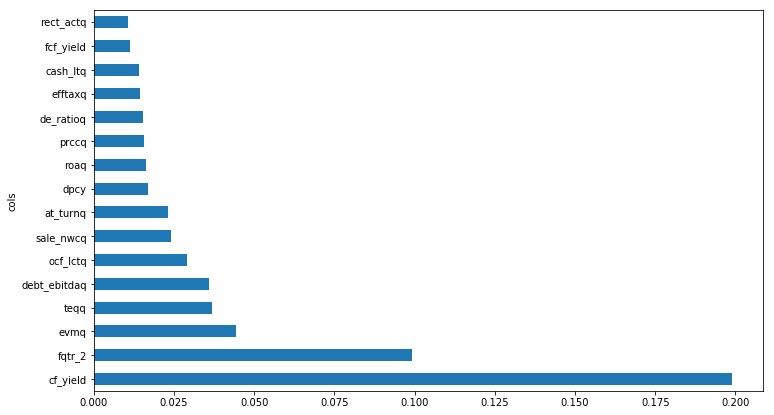

In [27]:
plot_fi(features);

In [28]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [29]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.5717380282988431

In [30]:
bg_clf.score(test,y_test)

0.5629784272790536

In [31]:
pred_valid = bg_clf.predict(test)

In [32]:
bg_clf.oob_score_

0.5611374844448541

### Profit importance

In [33]:
def profit_importance(t,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(20):
            X = df.copy()
            X[col] = np.random.permutation(df[col].values)
            prediction = t.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

def baggingtree_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [36]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


,cols,pi_imp
0,cf_yield,79.329185
2,evmq,87.871212
1,fqtr_2,92.644468
13,cash_ltq,93.977599
6,sale_nwcq,94.526655
11,de_ratioq,95.755807
15,rect_actq,95.838136
7,at_turnq,95.955127
12,efftaxq,96.042094
10,prccq,96.266329


In [38]:
profits = []

feat=[]

train1 = train.copy()
test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train1,y_1)
    pi = baggingtree_profit_importance(bg_clf,test1,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train1.drop(col_to_drop,axis=1,inplace=True)
    test1.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train1,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train1)
    features = fi[(fi['feat_imp'] > 0.00)]
    train1 = train1[features['cols'].values]
    test1 = test1[features['cols'].values]
    bg_clf.fit(train1,y_1)
    
    pred_valid = bg_clf.predict(test1)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


104.60446099999999
102.80183699999998
103.29585899999998
69.690589
67.91223300000001
64.15843700000002
63.83204300000001
65.56598100000002
66.83443500000001
66.32736300000002
64.28913300000002
71.38144500000001
92.507757
90.21270899999996


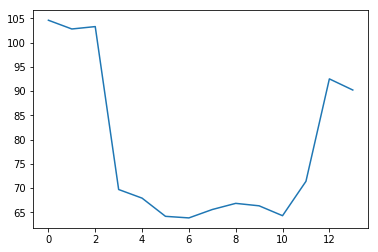

In [39]:
plt.plot(profits);

In [40]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [41]:
print(max_profits)
print(optim_feats)

104.60446099999999
['fcf_yield' 'ocf_lctq' 'fqtr_2' 'teqq' 'rect_actq' 'at_turnq' 'prccq'
 'dpcy' 'de_ratioq' 'evmq' 'efftaxq' 'roaq' 'sale_nwcq' 'cash_ltq']


In [45]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.5704014379868184
0.5615866388308977


104.60446099999999

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [46]:
from scipy.cluster import hierarchy as hc
import scipy.stats

In [107]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(35)]
end_dates = [d + pd.DateOffset(months = 120) for d in start_dates]

In [108]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [109]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]


In [110]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [111]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [112]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [113]:
len(training_labels)

35

In [114]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


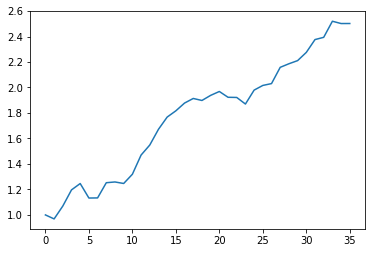

In [115]:
plt.plot(x);

In [1]:
import pickle5
with open("../Week2/crsp_prices.pkl", 'rb') as path:
    CRSP = pickle5.load(path)

In [2]:
CRSP.reset_index(inplace=True)
CRSP.set_index('date',inplace=True)

In [118]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [119]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

In [83]:
len(SPY.loc['2010-01-01':])
#len(SPY.loc['2003-01-01':])

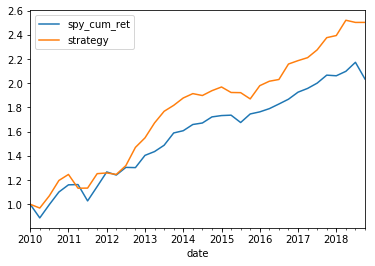

In [120]:
SPY['strategy'] = x
SPY.plot();

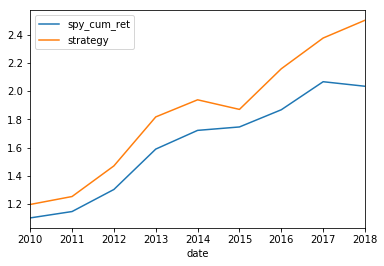

In [121]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [122]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.6989649383934442


In [123]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [124]:
x[-1]

2.502065579281544

In [125]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [126]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.38571809337749535

In [127]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.5658067398744527

In [128]:
alpha = np.mean(residual_ret)
alpha

0.03151896118492589

- Change hyper parameters for the BaggingClassifier and the DecisionTree and try at least 3 combinations of max_depth and n_estimators. Find optimal features and backtest with each of the combinations of hyperparameters.

## Max_depth 5, n_estimator 40


In [129]:
t_clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=800)

In [130]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,oob_score=True,random_state=123,n_jobs=1)

In [131]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [132]:
bg_clf.score(train,y_1)

0.5691109369958981

In [133]:
bg_clf.score(test,y_test)

0.5622825330549757

In [134]:
pred_valid = bg_clf.predict(test)

In [135]:
Counter(pred_valid)

Counter({1: 1338, -1: 99})

In [136]:
Counter(y_test)

Counter({-1: 642, 1: 795})

In [137]:
bg_clf.oob_score_

0.5578190533253445

In [138]:
confusion_matrix(y_test,pred_valid)

array([[ 56, 586],
       [ 43, 752]])

### Feature importance

In [139]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
105,cf_yield,0.207701
180,fqtr_2,0.104890
95,evmq,0.046030
55,teqq,0.038135
147,debt_ebitdaq,0.037840
152,ocf_lctq,0.029776
175,sale_nwcq,0.025635
170,at_turnq,0.022955
118,roaq,0.017236
87,prccq,0.016643


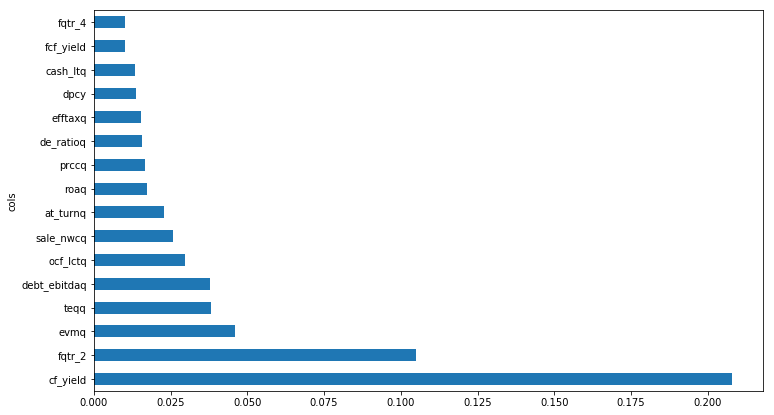

In [140]:
plot_fi(features);

In [141]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [142]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.5701249020601926

In [143]:
bg_clf.score(test,y_test)

0.5636743215031316

In [144]:
pred_valid = bg_clf.predict(test)

In [145]:
bg_clf.oob_score_

0.5606765912338111

### Profit importance

In [146]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.2 µs


,cols,pi_imp
0,cf_yield,80.817801
2,evmq,87.879910
1,fqtr_2,92.680583
6,sale_nwcq,93.839551
13,cash_ltq,94.211123
12,dpcy,94.716245
11,efftaxq,94.893870
9,prccq,95.123206
15,fqtr_4,95.346714
7,at_turnq,95.618704


In [148]:
profits = []

feat=[]

#train1 = train.copy()
#test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,test,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    test.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    train = train[features['cols'].values]
    test = test[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(test)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


97.193203
97.758347
97.36169699999999
97.174589
89.697967
88.632951
87.54484500000001
88.331537
88.260753
92.304979
87.67252299999998
86.79210699999996
69.72594099999995
66.54793099999999
91.70212699999999


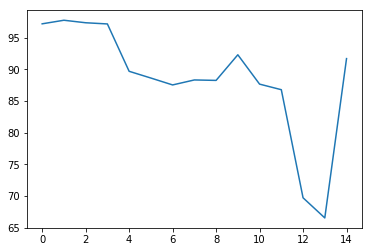

In [149]:
plt.plot(profits);

In [150]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [151]:
print(max_profits)
print(optim_feats)

97.758347
['cf_yield' 'fqtr_2' 'at_turnq' 'teqq' 'ocf_lctq' 'evmq' 'prccq'
 'sale_nwcq' 'roaq' 'dpcy' 'efftaxq' 'cash_ltq' 'fcf_yield' 'fqtr_4']


In [153]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.5702631700235056
0.5629784272790536


97.758347

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [154]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [155]:
len(training_labels)

35

In [156]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        #print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

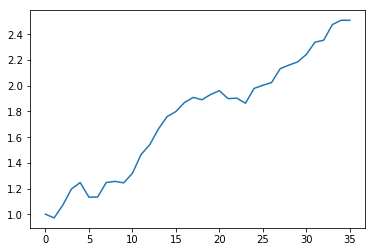

In [157]:
plt.plot(x);

In [158]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [159]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

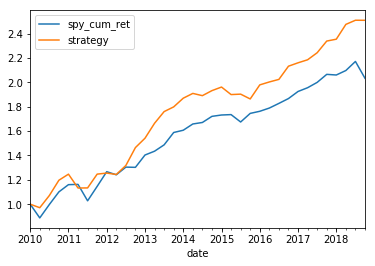

In [160]:
SPY['strategy'] = x
SPY.plot();

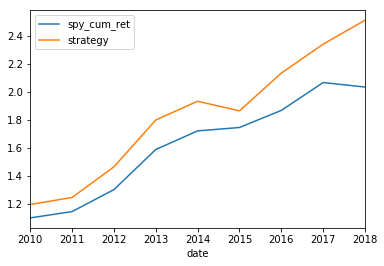

In [161]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [162]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.726713659547661


In [163]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [164]:
x[-1]

2.5105437889048052

In [165]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [166]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.3934597876226691

In [167]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.5912236243416128

In [168]:
alpha = np.mean(residual_ret)
alpha

0.031532444164034105

## Max_depth 6, n_estimator 50

In [169]:
t_clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=800)

In [170]:
bg_clf = BaggingClassifier(t_clf,n_estimators=50,oob_score=True,random_state=123,n_jobs=1)

In [171]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [172]:
bg_clf.score(train,y_1)

0.5704936166290271

In [173]:
bg_clf.score(test,y_test)

0.5650661099512874

In [174]:
pred_valid = bg_clf.predict(test)

In [175]:
Counter(pred_valid)

Counter({1: 1324, -1: 113})

In [176]:
Counter(y_test)

Counter({-1: 642, 1: 795})

In [177]:
bg_clf.oob_score_

0.5598008941328294

In [178]:
confusion_matrix(y_test,pred_valid)

array([[ 65, 577],
       [ 48, 747]])

### Feature importance

In [179]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
105,cf_yield,0.207218
180,fqtr_2,0.100726
95,evmq,0.047670
147,debt_ebitdaq,0.040290
55,teqq,0.036172
170,at_turnq,0.025170
152,ocf_lctq,0.023280
175,sale_nwcq,0.023025
162,de_ratioq,0.016929
87,prccq,0.016201


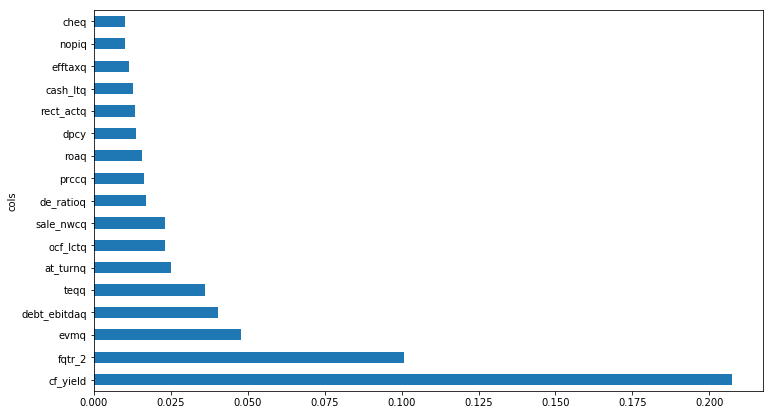

In [180]:
plot_fi(features);

In [181]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [182]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.571092777803383

In [183]:
bg_clf.score(test,y_test)

0.5581071677105081

In [184]:
pred_valid = bg_clf.predict(test)

In [185]:
bg_clf.oob_score_

0.5626123427201918

### Profit importance

In [186]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.9 µs


,cols,pi_imp
0,cf_yield,77.935040
2,evmq,89.146994
1,fqtr_2,94.447551
13,cash_ltq,94.579678
7,sale_nwcq,95.016153
12,rect_actq,95.185323
14,efftaxq,95.222301
9,prccq,95.318063
8,de_ratioq,95.522041
11,dpcy,95.542644


In [187]:
profits = []

feat=[]

#train1 = train.copy()
#test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,test,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    test.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    train = train[features['cols'].values]
    test = test[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(test)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


96.89495500000001
88.95083899999997
88.41711099999999
87.54235700000001
87.693725
87.802719
88.67999699999999
89.05028100000001
88.168405
87.301001
90.18386699999999
85.82926299999997
87.21593099999998
69.97104899999995
67.40263099999999
110.67640099999997


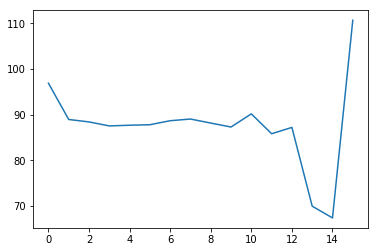

In [188]:
plt.plot(profits);

In [189]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [190]:
print(max_profits)
print(optim_feats)

110.67640099999997
['fqtr_2']


In [192]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.5457436511960179
0.5532359081419624


110.67640099999997

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [193]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [194]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        #print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

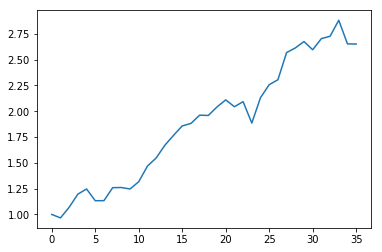

In [195]:
plt.plot(x);

In [196]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [197]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

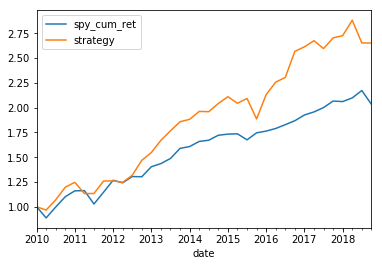

In [198]:
SPY['strategy'] = x
SPY.plot();

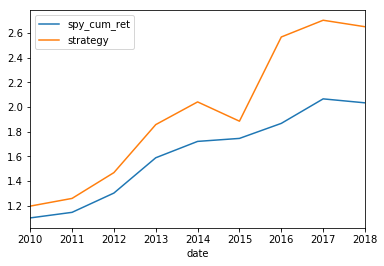

In [199]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [200]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.45511666889202773


In [201]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [202]:
x[-1]

2.651372469722583

In [203]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [204]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.2681840059202479

In [205]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.38927862411023456

In [206]:
alpha = np.mean(residual_ret)
alpha

0.0392577695565709

## Max_depth 8, n_estimator 40

In [245]:
t_clf = DecisionTreeClassifier(max_depth=8, min_samples_leaf=800)

In [246]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,oob_score=True,random_state=123,n_jobs=1)

In [247]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [248]:
bg_clf.score(train,y_1)

0.5701249020601926

In [249]:
bg_clf.score(test,y_test)

0.5608907446068198

In [250]:
pred_valid = bg_clf.predict(test)

In [251]:
Counter(pred_valid)

Counter({1: 1334, -1: 103})

In [252]:
Counter(y_test)

Counter({-1: 642, 1: 795})

In [253]:
bg_clf.oob_score_

0.5583260358574919

In [254]:
confusion_matrix(y_test,pred_valid)

array([[ 57, 585],
       [ 46, 749]])

### Feature importance

In [255]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
105,cf_yield,0.195778
180,fqtr_2,0.097067
95,evmq,0.043926
55,teqq,0.041348
147,debt_ebitdaq,0.034296
152,ocf_lctq,0.028881
175,sale_nwcq,0.023911
170,at_turnq,0.022759
118,roaq,0.017262
71,dpcy,0.016938


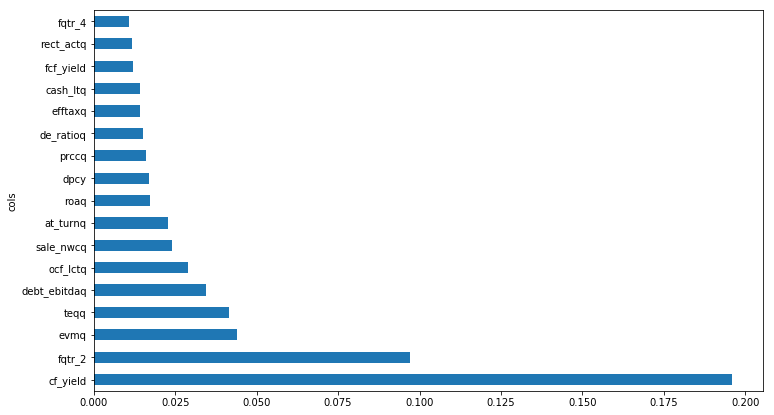

In [256]:
plot_fi(features);

In [257]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [258]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.571553671014426

In [259]:
bg_clf.score(test,y_test)

0.5615866388308977

In [260]:
pred_valid = bg_clf.predict(test)

In [261]:
bg_clf.oob_score_

0.5610913951237498

### Profit importance

In [262]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


,cols,pi_imp
0,cf_yield,80.631674
2,evmq,89.108940
1,fqtr_2,92.954430
13,cash_ltq,94.313956
6,sale_nwcq,95.158099
10,prccq,95.685496
11,de_ratioq,95.695336
15,rect_actq,95.916743
12,efftaxq,96.130383
16,fqtr_4,96.134548


In [263]:
profits = []

feat=[]

#train1 = train.copy()
#test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,test,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    test.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    train = train[features['cols'].values]
    test = test[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(test)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


98.658639
97.358711
98.505705
100.328159
98.89021699999998
90.49487699999997
93.734479
94.38246699999999
93.434669
93.306297
89.69808899999997
89.27828299999996
86.72910499999998
87.77672299999999
83.20275900000001
91.70212699999999


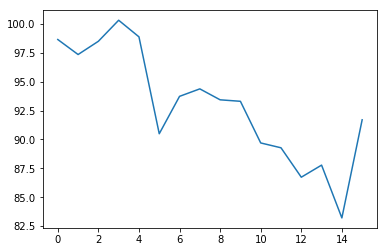

In [264]:
plt.plot(profits);

In [265]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [266]:
print(max_profits)
print(optim_feats)

100.328159
['cf_yield' 'fqtr_2' 'sale_nwcq' 'debt_ebitdaq' 'evmq' 'de_ratioq' 'prccq'
 'teqq' 'dpcy' 'cash_ltq' 'fcf_yield' 'fqtr_4' 'efftaxq']


In [268]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.571415403051113
0.5685455810716771


100.328159

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [269]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [270]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        #print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

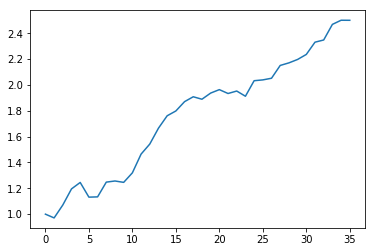

In [271]:
plt.plot(x);

In [272]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [273]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

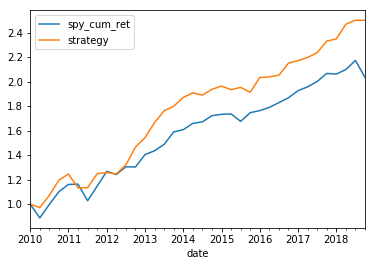

In [274]:
SPY['strategy'] = x
SPY.plot();

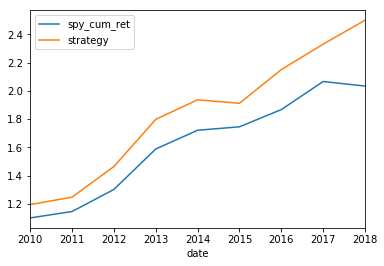

In [275]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [276]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7412705019881866


In [277]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [278]:
x[-1]

2.5000931042041725

In [279]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [280]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.36969575070315985

In [281]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.6107725118181019

In [282]:
alpha = np.mean(residual_ret)
alpha

0.03193603293548511

# `Question2`

- Insert a column in the data set with entries: 2 if the stock return is more then 5% higher than the SPY return, 1 if it is more than 1% but less than 5% higher, 0 if it is between -1% and 1%, -2 if the stock underperforms the SPY by more than -5% and -1 if the performance is between -1% and -5%


In [283]:
def f(x):
    if x > 0.05:
        return 2
    elif 0.05 >= x > 0.01:
        return 1
    elif 0.01 >= x > -0.01:
        return 0
    elif -0.01 >= x > -0.05:
        return -1
    else:
        return -2

In [284]:
data['rel_performance'] = \
data['pred_rel_return'].apply(f)

In [285]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,2
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


- Use the period 2007-2010 to train the model on the data set constructed above and construct a set of features that optimizes the profit of the long-short strategy on the quarter 2009-07-30 – 2009-10-30

In [286]:
df_1 = data.loc['2007-01-01':'2010-12-31']
df_2 = data.loc['2009-07-30':'2009-10-30']

In [424]:
train = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_2.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [288]:
train_stock_returns = df_1['next_period_return']
test_stock_returns = df_2['next_period_return']
y_1 = df_1['rel_performance']
y_test = df_2['rel_performance']
y_1 = y_1.values
y_test = y_test.values

## Max_depth 6, n_estimator 40

In [289]:
t_clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=800)

In [290]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,oob_score=True,random_state=123,n_jobs=1)

In [291]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [292]:
bg_clf.score(train,y_1)

0.41217679863575607

In [293]:
bg_clf.score(test,y_test)

0.37647877522616563

In [294]:
pred_valid = bg_clf.predict(test)

In [295]:
Counter(pred_valid)

Counter({2: 1412, -2: 25})

In [296]:
Counter(y_test)

Counter({-1: 205, 2: 545, 1: 203, -2: 368, 0: 116})

In [297]:
bg_clf.oob_score_

0.4087200995529336

In [298]:
confusion_matrix(y_test,pred_valid)

array([[  6,   0,   0,   0, 362],
       [  3,   0,   0,   0, 202],
       [  2,   0,   0,   0, 114],
       [  4,   0,   0,   0, 199],
       [ 10,   0,   0,   0, 535]])

### Feature importance

In [299]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
55,teqq,0.145735
105,cf_yield,0.113380
152,ocf_lctq,0.053518
86,dvpspq,0.051371
180,fqtr_2,0.047085
108,dprq,0.045844
156,fcf_yield,0.040796
87,prccq,0.032837
95,evmq,0.031599
76,oancfy,0.024306


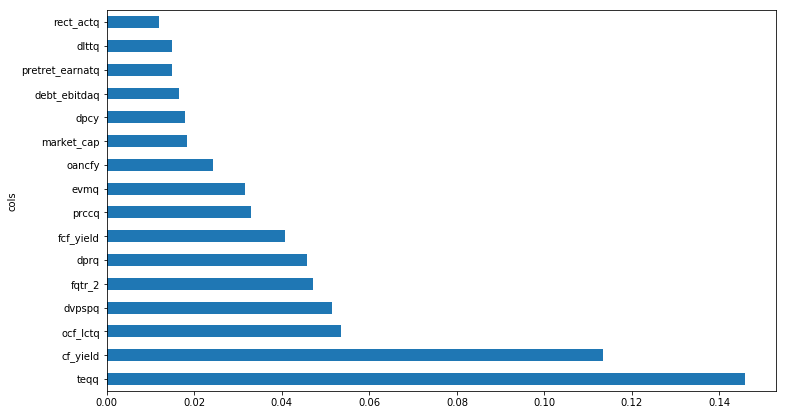

In [300]:
plot_fi(features);

In [301]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [302]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.4136055675899894

In [303]:
bg_clf.score(test,y_test)

0.3757828810020877

In [304]:
pred_valid = bg_clf.predict(test)

In [305]:
bg_clf.oob_score_

0.4096879752961239

### Profit importance

In [306]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


,cols,pi_imp
7,prccq,210.003359
3,dvpspq,210.539787
11,dpcy,211.458143
8,evmq,211.556749
5,dprq,211.854104
12,debt_ebitdaq,212.005064
10,market_cap,212.246730
13,pretret_earnatq,213.200023
4,fqtr_2,213.640969
15,rect_actq,213.657024


In [307]:
profits = []

feat=[]

#train1 = train.copy()
#test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,test,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    test.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    train = train[features['cols'].values]
    test = test[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(test)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


191.74618999999998
189.30367399999997
192.41240999999997
191.77887399999997
194.96428599999996
195.30798199999998
190.411402
191.142766
189.95985000000002
188.66352599999996
186.05321399999997
166.55563
166.86014600000004
151.50999399999995
221.35280199999994


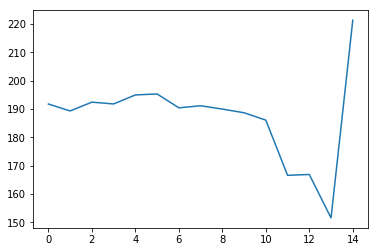

In [308]:
plt.plot(profits);

In [309]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [310]:
print(max_profits)
print(optim_feats)

221.35280199999994
['fqtr_2']


In [312]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.39724385859796285
0.3792623521224774


221.35280199999994

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [313]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [314]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        #print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

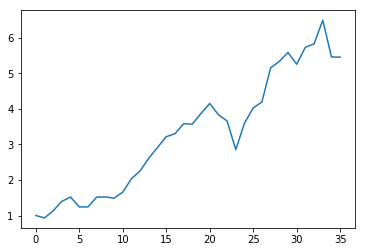

In [315]:
plt.plot(x);

In [316]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [317]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

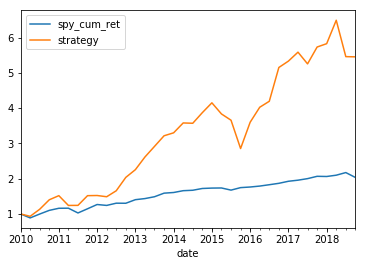

In [318]:
SPY['strategy'] = x
SPY.plot();

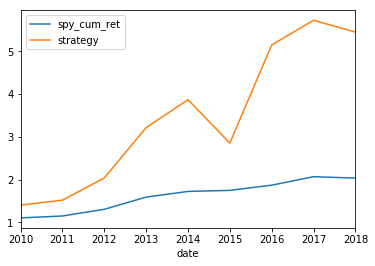

In [319]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [320]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.3348103336984732


In [321]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [322]:
x[-1]

5.452361751730794

In [323]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [324]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.6983907683732514

In [325]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.2864705044761436

In [326]:
alpha = np.mean(residual_ret)
alpha

0.10657428533984414

## Max_depth 8, n_estimator 40

In [327]:
t_clf = DecisionTreeClassifier(max_depth=8, min_samples_leaf=800)

In [328]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40,oob_score=True,random_state=123,n_jobs=1)

In [329]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=40, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [330]:
bg_clf.score(train,y_1)

0.4119924413513389

In [331]:
bg_clf.score(test,y_test)

0.37647877522616563

In [332]:
pred_valid = bg_clf.predict(test)

In [333]:
Counter(pred_valid)

Counter({2: 1412, -2: 25})

In [334]:
Counter(y_test)

Counter({-1: 205, 2: 545, 1: 203, -2: 368, 0: 116})

In [335]:
bg_clf.oob_score_

0.4088122781951422

In [336]:
confusion_matrix(y_test,pred_valid)

array([[  6,   0,   0,   0, 362],
       [  3,   0,   0,   0, 202],
       [  2,   0,   0,   0, 114],
       [  4,   0,   0,   0, 199],
       [ 10,   0,   0,   0, 535]])

### Feature importance

In [337]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
55,teqq,0.145151
105,cf_yield,0.113602
152,ocf_lctq,0.053518
86,dvpspq,0.050954
180,fqtr_2,0.046557
108,dprq,0.045496
156,fcf_yield,0.040693
87,prccq,0.032574
95,evmq,0.032238
76,oancfy,0.024306


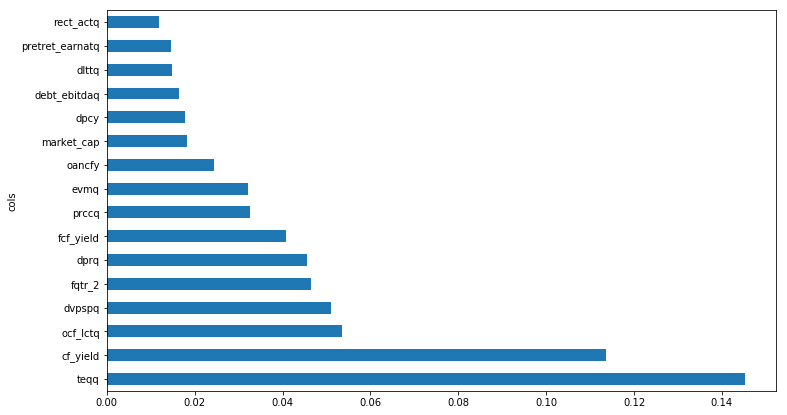

In [338]:
plot_fi(features);

In [339]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [340]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.4135594782688851

In [341]:
bg_clf.score(test,y_test)

0.3757828810020877

In [342]:
pred_valid = bg_clf.predict(test)

In [343]:
bg_clf.oob_score_

0.4096879752961239

### Profit importance

In [344]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


,cols,pi_imp
7,prccq,210.249168
3,dvpspq,210.486974
8,evmq,211.700916
11,dpcy,211.946926
5,dprq,211.948187
10,market_cap,212.045119
12,debt_ebitdaq,212.093153
14,pretret_earnatq,213.207670
13,dlttq,213.414718
4,fqtr_2,214.331877


In [345]:
profits = []

feat=[]

#train1 = train.copy()
#test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,test,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    test.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    train = train[features['cols'].values]
    test = test[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(test)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


191.74618999999998
194.26880599999998
193.01870199999996
196.95644199999995
194.42761799999997
196.929242
193.74878199999995
192.245558
190.63779
199.89546199999998
195.77152999999998
168.41101
166.86014600000004
151.50999399999995
221.35280199999994


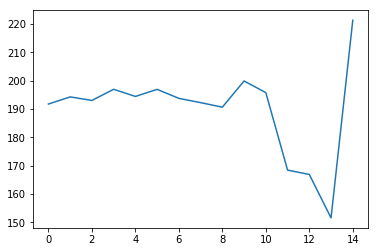

In [346]:
plt.plot(profits);

In [347]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [348]:
print(max_profits)
print(optim_feats)

221.35280199999994
['fqtr_2']


In [350]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.39724385859796285
0.3792623521224774


221.35280199999994

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [351]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [352]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        #print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

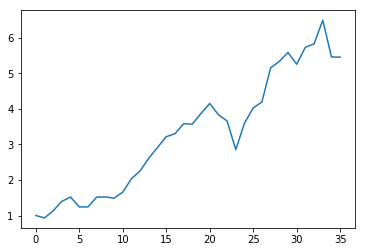

In [353]:
plt.plot(x);

In [354]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [355]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

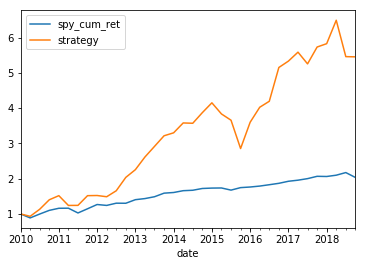

In [356]:
SPY['strategy'] = x
SPY.plot();

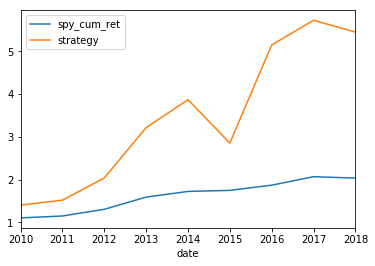

In [357]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [358]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.3348103336984732


In [359]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [360]:
x[-1]

5.452361751730794

In [361]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [362]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.6983907683732514

In [363]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.2864705044761436

In [364]:
alpha = np.mean(residual_ret)
alpha

0.10657428533984414

## Max_depth 8, n_estimator 30

In [366]:
t_clf = DecisionTreeClassifier(max_depth=8, min_samples_leaf=800)

In [367]:
bg_clf = BaggingClassifier(t_clf,n_estimators=30,oob_score=True,random_state=123,n_jobs=1)

In [368]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [369]:
bg_clf.score(train,y_1)

0.4129142277734249

In [370]:
bg_clf.score(test,y_test)

0.3771746694502436

In [371]:
pred_valid = bg_clf.predict(test)

In [372]:
Counter(pred_valid)

Counter({2: 1411, -2: 26})

In [373]:
Counter(y_test)

Counter({-1: 205, 2: 545, 1: 203, -2: 368, 0: 116})

In [374]:
bg_clf.oob_score_

0.40890445683735077

In [375]:
confusion_matrix(y_test,pred_valid)

array([[  7,   0,   0,   0, 361],
       [  3,   0,   0,   0, 202],
       [  2,   0,   0,   0, 114],
       [  4,   0,   0,   0, 199],
       [ 10,   0,   0,   0, 535]])

### Feature importance

In [376]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
55,teqq,0.146738
105,cf_yield,0.112546
152,ocf_lctq,0.069311
86,dvpspq,0.056139
156,fcf_yield,0.047714
180,fqtr_2,0.045954
108,dprq,0.041013
87,prccq,0.039215
95,evmq,0.031168
76,oancfy,0.022753


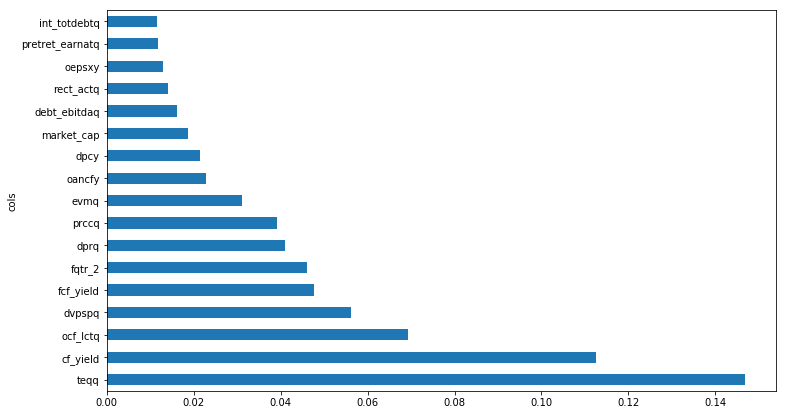

In [377]:
plot_fi(features);

In [378]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [379]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.4130985850578421

In [380]:
bg_clf.score(test,y_test)

0.3757828810020877

In [381]:
pred_valid = bg_clf.predict(test)

In [382]:
bg_clf.oob_score_

0.4074756878831175

### Profit importance

In [383]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 14.1 µs


,cols,pi_imp
8,evmq,212.793885
7,prccq,212.896459
12,debt_ebitdaq,213.324052
11,market_cap,213.394502
6,dprq,213.555762
16,int_totdebtq,214.573627
14,oepsxy,214.753704
15,pretret_earnatq,214.926712
10,dpcy,215.043284
1,cf_yield,215.291777


In [384]:
profits = []

feat=[]

#train1 = train.copy()
#test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,test,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    test.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    train = train[features['cols'].values]
    test = test[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(test)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


189.54364199999998
190.90102599999994
192.48913799999997
191.88770999999997
197.691282
199.22990999999996
199.698166
199.44695399999998
197.764074
194.86115399999997
197.63974199999996
189.86573399999997
168.88045
168.16519800000006
149.65778199999997
221.35280199999994


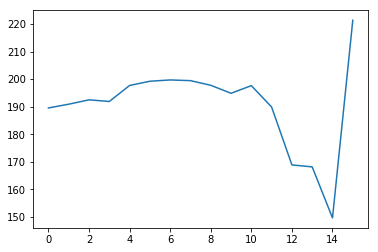

In [385]:
plt.plot(profits);

In [386]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [387]:
print(max_profits)
print(optim_feats)

221.35280199999994
['fqtr_2']


In [389]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.39724385859796285
0.3792623521224774


221.35280199999994

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [390]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [391]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        #print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

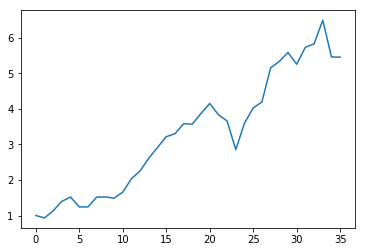

In [392]:
plt.plot(x);

In [393]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [394]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

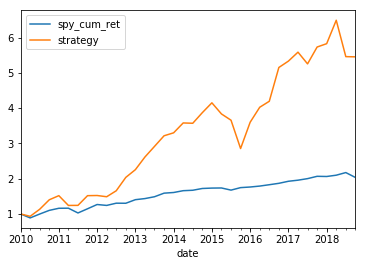

In [395]:
SPY['strategy'] = x
SPY.plot();

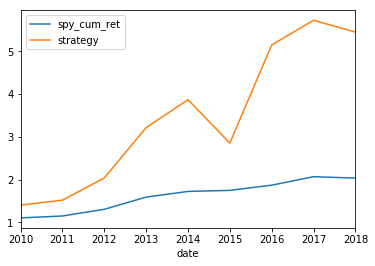

In [396]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [397]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.3348103336984732


In [398]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [399]:
x[-1]

5.452361751730794

In [400]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [401]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.6983907683732514

In [402]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.2864705044761436

In [403]:
alpha = np.mean(residual_ret)
alpha

0.10657428533984414

## Max_depth 6, n_estimator 30

In [404]:
t_clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=800)

In [405]:
bg_clf = BaggingClassifier(t_clf,n_estimators=30,oob_score=True,random_state=123,n_jobs=1)

In [406]:
bg_clf.fit(train,y_1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=800, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=30, n_jobs=1, oob_score=True,
         random_state=123, verbose=0, warm_start=False)

In [407]:
bg_clf.score(train,y_1)

0.4129142277734249

In [408]:
bg_clf.score(test,y_test)

0.3771746694502436

In [409]:
pred_valid = bg_clf.predict(test)

In [410]:
Counter(pred_valid)

Counter({2: 1411, -2: 26})

In [411]:
Counter(y_test)

Counter({-1: 205, 2: 545, 1: 203, -2: 368, 0: 116})

In [412]:
bg_clf.oob_score_

0.4087200995529336

In [413]:
confusion_matrix(y_test,pred_valid)

array([[  7,   0,   0,   0, 361],
       [  3,   0,   0,   0, 202],
       [  2,   0,   0,   0, 114],
       [  4,   0,   0,   0, 199],
       [ 10,   0,   0,   0, 535]])

### Feature importance

In [414]:
fi = baggingtree_feat_importance(bg_clf,train)
features = fi[(fi['feat_imp'] > 0.01)]
features

,cols,feat_imp
55,teqq,0.147312
105,cf_yield,0.111766
152,ocf_lctq,0.069311
86,dvpspq,0.056390
156,fcf_yield,0.047852
180,fqtr_2,0.046306
108,dprq,0.041425
87,prccq,0.039566
95,evmq,0.030234
76,oancfy,0.022753


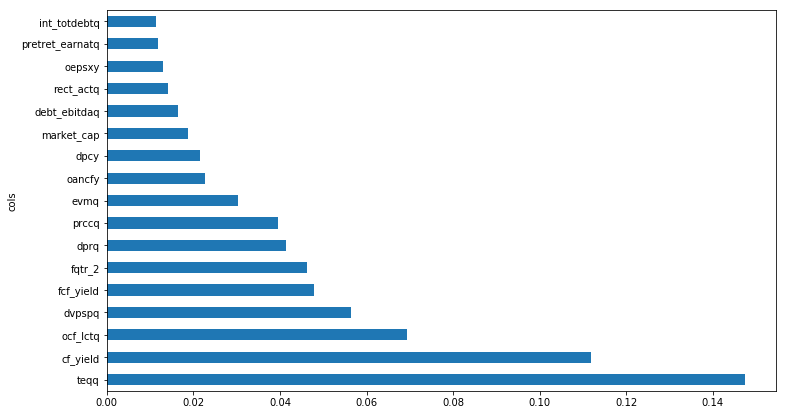

In [415]:
plot_fi(features);

In [416]:
train = train[features['cols'].values]
test = test[features['cols'].values]

In [417]:
bg_clf.fit(train,y_1)
bg_clf.score(train,y_1)

0.4130985850578421

In [418]:
bg_clf.score(test,y_test)

0.3757828810020877

In [419]:
pred_valid = bg_clf.predict(test)

In [420]:
bg_clf.oob_score_

0.4074756878831175

### Profit importance

In [421]:
%time 
pi = baggingtree_profit_importance(bg_clf,test,df_2['next_period_return'])
pi

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 15.3 µs


,cols,pi_imp
8,evmq,212.903864
7,prccq,213.040224
11,market_cap,213.179102
6,dprq,213.621893
12,debt_ebitdaq,213.929739
16,int_totdebtq,214.693636
14,oepsxy,214.763216
15,pretret_earnatq,215.010088
3,dvpspq,215.260718
0,teqq,215.698934


In [422]:
profits = []

feat=[]

#train1 = train.copy()
#test1 = test.copy()

while len(train.columns)>1:
    bg_clf.fit(train,y_1)
    pi = baggingtree_profit_importance(bg_clf,test,y_test)

    col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
    train.drop(col_to_drop,axis=1,inplace=True)
    test.drop(col_to_drop,axis=1,inplace=True)
    bg_clf.fit(train,y_1)
    
    fi = baggingtree_feat_importance(bg_clf,train)
    features = fi[(fi['feat_imp'] > 0.00)]
    train = train[features['cols'].values]
    test = test[features['cols'].values]
    bg_clf.fit(train,y_1)
    
    pred_valid = bg_clf.predict(test)
    profits.append((pred_valid * df_2['next_period_return']).sum())
    print((pred_valid * df_2['next_period_return']).sum())
    feat.append(features['cols'].values) 
    


189.54364199999998
191.38295
192.48913799999997
191.50430599999996
192.48913799999997
199.17024999999998
199.228566
199.98049399999996
199.89824999999996
197.02437799999996
190.98569399999997
189.86573399999997
168.88045
168.16519800000006
149.65778199999997
221.35280199999994


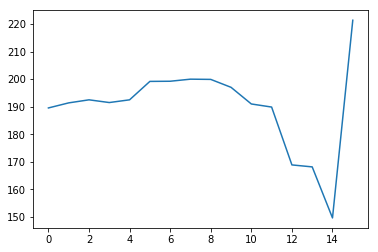

In [423]:
plt.plot(profits);

In [425]:
n = np.argmax(profits)
optim_feats = feat[n]
max_profits = profits[n]

In [426]:
print(max_profits)
print(optim_feats)

221.35280199999994
['fqtr_2']


In [427]:
train_optim = train[optim_feats]
test_optim = test[optim_feats]

bg_clf.fit(train_optim,y_1)
print(bg_clf.score(train_optim,y_1))
pred_valid_tree = bg_clf.predict(test_optim)
print(bg_clf.score(test_optim,y_test))
(pred_valid_tree * df_2['next_period_return']).sum()

0.39724385859796285
0.3792623521224774


221.35280199999994

### Backtest
- Backtest the performance of the model with the optimal features over the period 2010 – 2018.
---------------------------------

In [428]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [429]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)):
        #print(i)
        bg_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = bg_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

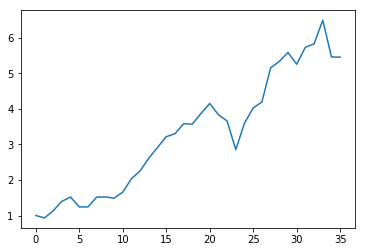

In [430]:
plt.plot(x);

In [431]:
SPY = CRSP[['spy_cum_ret']]
SPY = SPY[~SPY.index.duplicated(keep='first')]
SPY = SPY.loc['2010-01-01':]

In [432]:
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

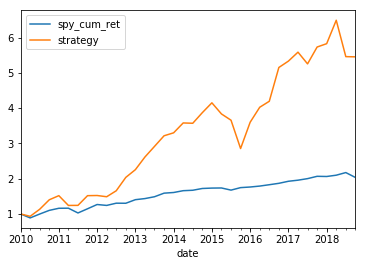

In [433]:
SPY['strategy'] = x
SPY.plot();

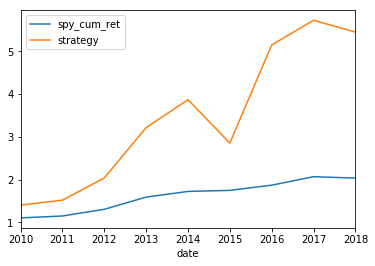

In [434]:
SPY.resample('Y').ffill().plot()

- Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the buy-and-hold strategy for SPY

In [435]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.3348103336984732


In [436]:
(SPY['spy_cum_ret'] - 1).diff().mean()
(SPY['spy_cum_ret'] - 1).diff().std()
print('SP Sharpe Ratio: ',(SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std())

SP Sharpe Ratio:  0.46133385900210633


In [437]:
x[-1]

5.452361751730794

In [438]:
SPY['spy_cum_ret'][-1]

2.034179999999999

In [439]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.6983907683732514

In [440]:
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

0.2864705044761436

In [441]:
alpha = np.mean(residual_ret)
alpha

0.10657428533984414